<h2> 1) Setup and load Data <h3>

<h3> 1.1) Install Dependencies and setup 

In [ ]:
 !pip install tensorflow tensorflow-gpu opencv-python matplotlib
 !pip install imgaug
 !pip install numpy==1.22.0
 !pip install scipy==1.8.0

In [ ]:
# !pip list

In [1]:
import tensorflow as tf
import os

2024-02-14 10:39:12.711539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 10:39:12.711652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 10:39:12.878394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Avoid Out Of Memory errors by setting GPU memory consumption Growth(Only applicable during local runs)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# gpus

<h3> 1.2) Remove dodgy images

In [2]:
import cv2
import imghdr

In [3]:
data_dir = '/kaggle/input/plant-leaf-dataset/Plant leaves dataset'

In [4]:
# Get the class labels from folder names
class_names = sorted(os.listdir(data_dir))

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
Cleaning up dodgy images and unsupported files found in the dataset
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))

<h3> 1.3) Load Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# Creating a image dataset using keras
data = tf.keras.utils.image_dataset_from_directory(data_dir,label_mode='categorical')

Found 786 files belonging to 4 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [12]:
# Labels for the images
batch[1]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

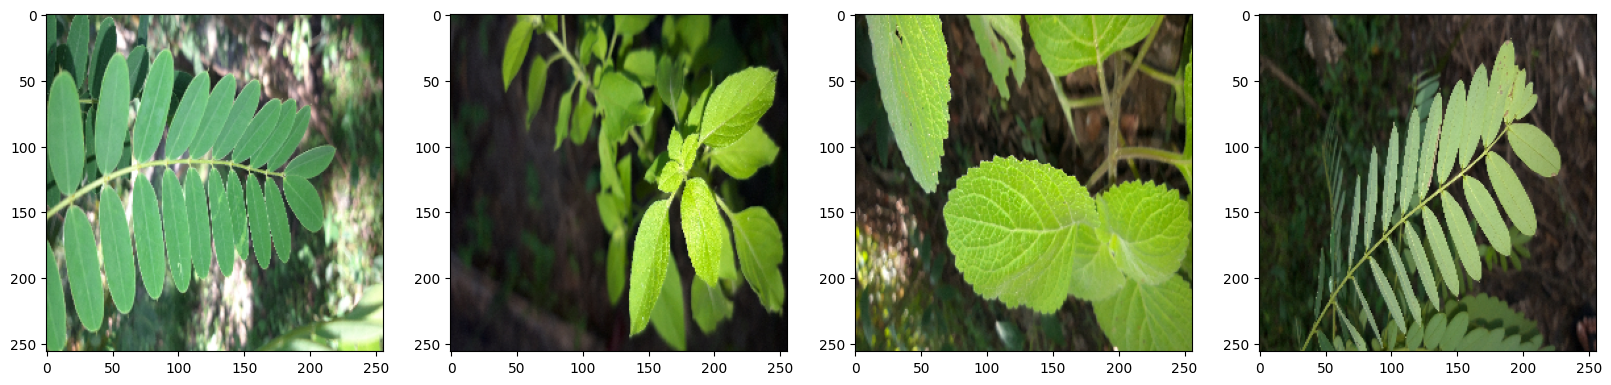

In [13]:
# Visualizing the dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

<h2> 2) Preprocess Data <h3>

<h3> 2.1) Scale data

In [15]:
# Scaling is done for optimization for the deep learning model
# scale the image numpy array vals to be between 0 and 1
scaled_data = data.map(lambda x, y: (x/255, y))

In [16]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [17]:
scaled_batch = scaled_iterator.next()

In [18]:
scaled_batch[0].shape

(32, 256, 256, 3)

In [19]:
scaled_batch[0].max()

1.0

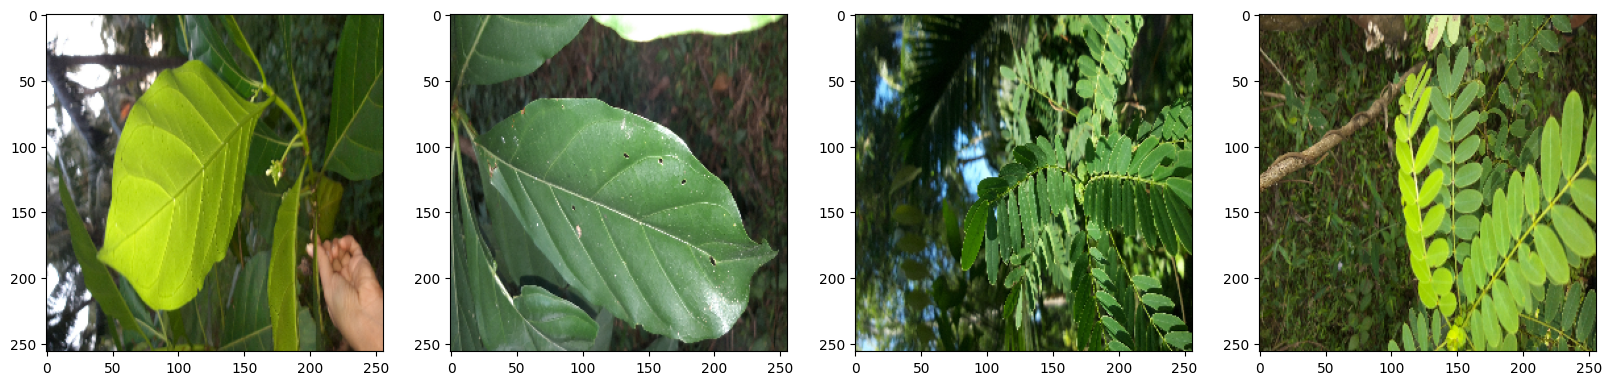

In [20]:
# Visualizing the scaled dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
#     ax[idx].title.set_text(scaled_batch[1][idx])

<h3> 2.2) Split data

In [21]:
# No of batches
len(data)

25

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [23]:
# Splitting the dataset into 70% training, 20% validation and 10% testing
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
# No of batches for each train,val,test datasets
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Train size: 17
Validation size: 5
Test size: 3


<h2>Augmentation func

In [25]:
# from imgaug import augmenters as iaa
from tensorflow.keras import layers

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.4),
#     layers.RandomContrast(0.3),
#     layers.RandomTranslation(
#         0.2,
#         0.35,
#         fill_mode='reflect',
#         interpolation='bilinear',
#         seed=None,
#         fill_value=0.2),
#     layers.LayerNormalization(
#     axis=-1,
#     epsilon=0.002,
#     center=True,
#     scale=True,
#     beta_initializer="zeros",
#     gamma_initializer="ones",
#     beta_regularizer=None,
#     gamma_regularizer=None,
#     beta_constraint=None,
#     gamma_constraint=None
# )
# ])

<h2> 3) Deep Learning Model

<h3> 3.1) Build the deep learning model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Lambda, AveragePooling2D, GlobalAveragePooling2D

In [27]:
model = Sequential(name="Plant_Leaf_Classification")

In [28]:
# Adding layers to the NN
# data_augmentation,
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))


# New architecture
# data_augmentation,

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(3, activation='softmax'))

In [29]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "Plant_Leaf_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 3

<h3> 3.2) Train the model

In [31]:
logdir = 'logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [33]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5


I0000 00:00:1707907335.467300     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 53s 2s/step - loss: 109.2313 - accuracy: 0.2776 - val_loss: 1.2010 - val_accuracy: 0.4375
Epoch 2/5
17/17 [==============================] - 47s 2s/step - loss: 1.1584 - accuracy: 0.4945 - val_loss: 1.0440 - val_accuracy: 0.6062
Epoch 3/5
17/17 [==============================] - 46s 2s/step - loss: 0.7834 - accuracy: 0.7059 - val_loss: 0.6489 - val_accuracy: 0.7563
Epoch 4/5
17/17 [==============================] - 47s 2s/step - loss: 0.4440 - accuracy: 0.8438 - val_loss: 0.4945 - val_accuracy: 0.8687
Epoch 5/5
17/17 [==============================] - 47s 2s/step - loss: 0.2702 - accuracy: 0.9228 - val_loss: 0.3346 - val_accuracy: 0.8875


In [ ]:
model_name = './plant_leaf_classification_5Epoch.h5'

In [ ]:
# Save the trained model
model.save(model_name)

<h3> 3.3) Plot Performance

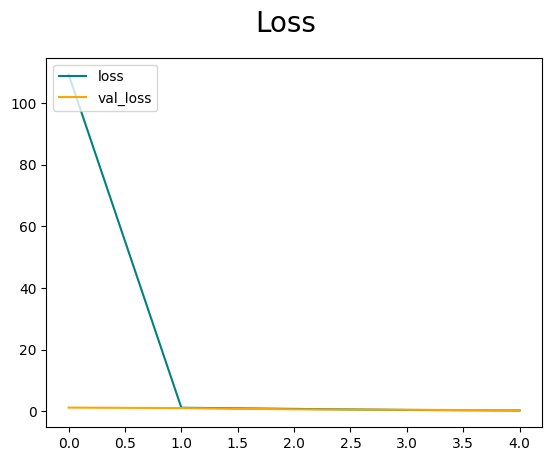

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

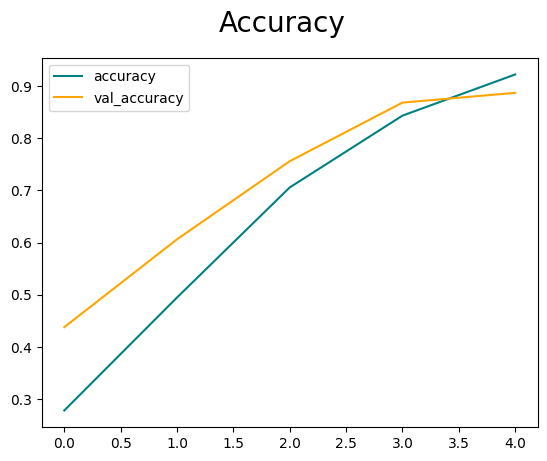

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h2> 4) Evaluate Performance

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
# Initialize the true labels and predicted labels lists
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
    # Convert the predicted probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)
    y_classes = np.argmax(y, axis=1)
    
    # Update the true and predicted labels lists
    y_true.extend(y_classes.tolist())
    y_pred.extend(yhat_classes.tolist())

1/1 [==============================] - 0s 463ms/step


In [39]:
# Printing the evaluation values
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9508196711540222, Recall:0.707317054271698, Accuracy:0.8048780560493469


<h3> Plotting confusion matrix

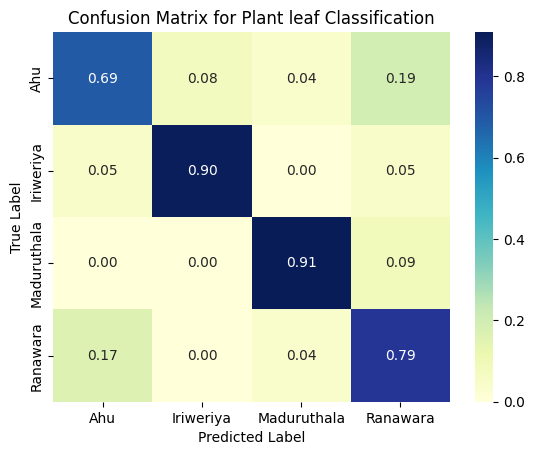

In [40]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', 
                xticklabels=['Ahu', 'Iriweriya', 'Maduruthala', 'Ranawara'],
                yticklabels=['Ahu', 'Iriweriya', 'Maduruthala', 'Ranawara'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Plant leaf Classification')
plt.savefig("Confusion Matrix for Plant leaf Classification") # save as png
plt.show()

In [41]:
class_labels = list(class_names)

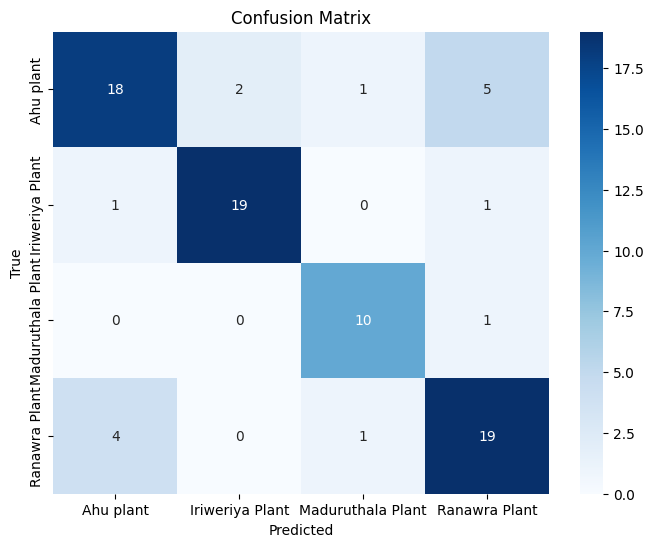

In [42]:
# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<h2> Testing

In [43]:
from tensorflow.keras.models import load_model

In [ ]:
new_model = load_model('/kaggle/working/'+ model_name)

In [ ]:
test = '/kaggle/input/plant-leaf-dataset/Plant leaves dataset/Iriweriya Plant/20240118_084502.jpg'

test_img = cv2.imread(test)

temp_test = tf.image.resize(test_img, (256,256))
resize_test = temp_test.numpy().astype(int)

plt.imshow(resize_test)
plt.show()

In [ ]:
yhatNew = new_model.predict(np.expand_dims(resize_test/224, 0))

plant_leaf_labels = class_labels
leaf = plant_leaf_labels[np.argmax(yhatNew[0])]
yhatNew
print(yhatNew)
print('Plant Leaf :', leaf)

In [ ]:
from IPython.display import FileLink 
FileLink(r'plant_leaf_classification_5Epoch.h5')